# Importações

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import sys
sys.path.insert(1, '../predict_stock_mvp/pre_train/')
import load_data
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from gluonts.dataset.pandas import PandasDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import make_evaluation_predictions, Evaluator

# Carregando dados

In [3]:
data = load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [4]:
data.head()

,NUMERO_REGISTRO_PRODUTO,IDENTIFICADOR_DO_ITEM,NOME_PRODUTO,DATA_DE_CONSUMO,QUANTIDADE_SAIDA
0,10277002,25991014035,BILAGOGO,2020-02-29,21
1,10277002,25991014035,BILAGOGO,2020-03-31,18
2,10277002,25991014035,BILAGOGO,2020-04-30,56
3,10277002,25991014035,BILAGOGO,2020-05-31,0
4,10277002,25991014035,BILAGOGO,2020-06-30,21


# Criando teste de pipeline para DeepAr
https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d

## Pré processamento

In [5]:
data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]

In [6]:
data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")

C:\Users\anton\AppData\Local\Temp\ipykernel_1636\405872292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


In [7]:
data_para_processamento.head()

,QUANTIDADE_SAIDA,NUMERO_REGISTRO_PRODUTO
DATA_DE_CONSUMO,,
2020-02-29,21,10277002
2020-03-31,18,10277002
2020-04-30,56,10277002
2020-05-31,0,10277002
2020-06-30,21,10277002


In [8]:
prediction_length = 6

data_para_processamento_new = pd.DataFrame(None, columns = data_para_processamento.columns)
for n in tqdm(data_para_processamento.NUMERO_REGISTRO_PRODUTO.unique()):
    frame_train = data_para_processamento.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iloc[:-prediction_length]
    data_para_processamento_new = pd.concat([data_para_processamento_new, frame_train])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 85.67it/s]


In [9]:
train = PandasDataset.from_long_dataframe(data_para_processamento_new, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")

## Treinamento

In [10]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=prediction_length,
    context_length=16,
    num_layers = 2,
    num_cells = 50,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))

predictor = estimator.train(train)

100%|████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.50it/s, epoch=10/10, avg_epoch_loss=4.13]


## Predição

In [11]:
import sys
sys.path.insert(1, '../predict_stock_mvp/pre_train/')
import load_data

In [12]:
table_test = load_data.conect_data.load_table('../../data/data_processed/', 'processed.predict', 'csv', sep=",")

In [13]:
table_test.head(24)

,NUMERO_REGISTRO_PRODUTO,DATA_DE_CONSUMO,QUANTIDADE_SAIDA,PREDICAO_MEDIA_MOVEL
0,10277002,2020-02-29,21,NaN
1,10277002,2020-03-31,18,NaN
2,10277002,2020-04-30,56,NaN
3,10277002,2020-05-31,0,31.666667
4,10277002,2020-06-30,21,24.666667
5,10277002,2020-07-31,8,25.666667
6,10277002,2020-08-31,30,9.666667
7,10277002,2020-09-30,17,19.666667
8,10277002,2020-10-31,16,18.333333
9,10277002,2020-11-30,5,21.000000


In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [15]:
forecasts[0].samples.tolist()[0]

[25.863399505615234,
 19.711021423339844,
 40.32351303100586,
 5.658574104309082,
 9.974432945251465,
 25.408618927001953]

In [16]:
for n in forecasts:
    print(n.samples)

[[25.8634   19.711021 40.323513  5.658574  9.974433 25.408619]]
[[ 35.619274 -12.449715  -3.852687  25.52369    9.387935  40.19044 ]]
[[ 21.063377  22.698273  19.168562   8.39496   41.918392 -84.8175  ]]
[[ 1.2845163  9.755082   6.5261784 13.548996  25.28676   24.03514  ]]
[[  1.2262875  31.19589    44.78755   -25.279593   52.284325   26.47867  ]]
[[38.9178    -7.8036532  2.7508636 17.511911  23.741596  77.21391  ]]
[[-1.8223733 30.82958   31.748793  24.794655   9.543598  27.044106 ]]
[[24.960875  24.40617   39.205467  15.823553  19.341541  -6.4938827]]
[[ 9.778693 31.4509   27.869558 57.06292  28.60272  20.998653]]
[[-9.213225  53.623547  14.653669   2.7838771 22.26178   16.44072  ]]
[[32.789116  20.255611  43.71753   13.8014965 11.274901  -0.4186653]]
[[21.327162  10.440656   4.84185   -6.0439196 20.605814  42.864334 ]]
[[28.583153 14.976154 20.777319 33.486275 28.061377 28.21625 ]]
[[ 30.823484 -13.801105   2.661882  30.7684    33.303127 -11.026266]]
[[37.268173  48.745125  35.54654

In [17]:
for n in table_test.DATA_DE_CONSUMO:
    if n.find(str(forecasts[0].start_date)) == 0:
        filtro = n
        break

In [18]:
data_input = table_test.query(f"DATA_DE_CONSUMO >= '{filtro}'")
data_input["PREDICAO_DEEPAR"] = float('nan')

contador_itens = 0
for n in tqdm(data_input.NUMERO_REGISTRO_PRODUTO.unique()):
    lista_de_predicao = forecasts[contador_itens]
    contador_itens = contador_itens + 1
    
    contador_valores = 0
    for idx, linha in data_input.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iterrows():
        linha["PREDICAO_DEEPAR"] = lista_de_predicao.samples.tolist()[0][contador_valores]
        contador_valores = contador_valores + 1

C:\Users\anton\AppData\Local\Temp\ipykernel_1636\3882306943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input["PREDICAO_DEEPAR"] = float('nan')
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 293.51it/s]


In [19]:
data_input

,NUMERO_REGISTRO_PRODUTO,DATA_DE_CONSUMO,QUANTIDADE_SAIDA,PREDICAO_MEDIA_MOVEL,PREDICAO_DEEPAR
18,10277002,2021-08-31,1,29.333333,NaN
19,10277002,2021-09-30,2,22.666667,NaN
20,10277002,2021-10-31,29,7.333333,NaN
21,10277002,2021-11-30,1,10.666667,NaN
22,10277002,2021-12-31,12,10.666667,NaN
...,...,...,...,...,...
47995,996640035,2021-09-30,81,10.666667,NaN
47996,996640035,2021-10-31,21,36.000000,NaN
47997,996640035,2021-11-30,21,35.333333,NaN
47998,996640035,2021-12-31,0,41.000000,NaN


## Avaliação

In [ ]:
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test))

In [78]:
print(agg_metrics["MSE"])
print(agg_metrics["RMSE"])
print(agg_metrics["abs_target_mean"])

262.8029413763682
16.211198024093353
19.2755


In [79]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,...,QuantileLoss[0.75],Coverage[0.75],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.85],Coverage[0.85],QuantileLoss[0.9],Coverage[0.9],QuantileLoss[0.95],Coverage[0.95]
0,10277002,235.429362,95.859818,81.0,13.500000,20.000000,0.798832,8.135265,1.171731,1.183455,...,66.201098,0.833333,58.601738,0.833333,45.952903,0.833333,33.458103,1.000000,21.816572,1.000000
1,100020070,299.508219,88.788132,139.0,23.166667,30.000000,0.493267,1.809371,0.777227,0.638764,...,64.213536,0.666667,59.356248,0.666667,49.248332,0.833333,39.179298,0.833333,23.643913,0.833333
2,100020082,80.080053,46.868641,104.0,17.333333,16.666667,0.468686,0.728490,0.492121,0.450660,...,36.683320,0.833333,31.665871,0.833333,26.960888,0.833333,20.823294,1.000000,14.185940,1.000000
3,100020086,144.893188,63.979836,138.0,23.000000,19.166667,0.556346,3.576027,0.607440,0.463622,...,38.060259,0.500000,26.767860,0.833333,23.127240,1.000000,21.858945,1.000000,15.499274,1.000000
4,100020095,108.032206,56.407021,88.0,14.666667,18.333333,0.512791,1.063701,0.650054,0.640989,...,51.952427,0.833333,46.601894,0.833333,38.830064,0.833333,25.676136,1.000000,16.318693,1.000000


In [80]:
forecasts[0].samples.shape

(100, 6)

In [81]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id="10277002", samples=numpy.array([[15.389383316040039, 26.820993423461914, 18.47747230529785, -32.38889694213867, -15.047815322875977, 2.7162866592407227], [52.01507568359375, -3.1591131687164307, 21.01426887512207, 29.283945083618164, 33.74509811401367, 19.450538635253906], [18.62674331665039, 25.09619140625, -6.840397357940674, 5.23148250579834, 16.9002628326416, 40.196075439453125], [25.116186141967773, 31.31350326538086, 17.89103889465332, -5.361596584320068, 16.006488800048828, 15.64382266998291], [56.481178283691406, 44.666011810302734, 29.680177688598633, 19.278100967407227, -1.9313313961029053, 4.165013313293457], [37.311767578125, 9.797402381896973, 29.458433151245117, 10.514760971069336, -2.4270644187927246, 8.83779239654541], [12.155244827270508, -4.279908180236816, 36.34956741333008, 12.019804954528809, 42.30571365356445, 2.1522469520568848], [9.920302391052246, 23.893224716186523, 8.669940948486328, 25.608705520629883

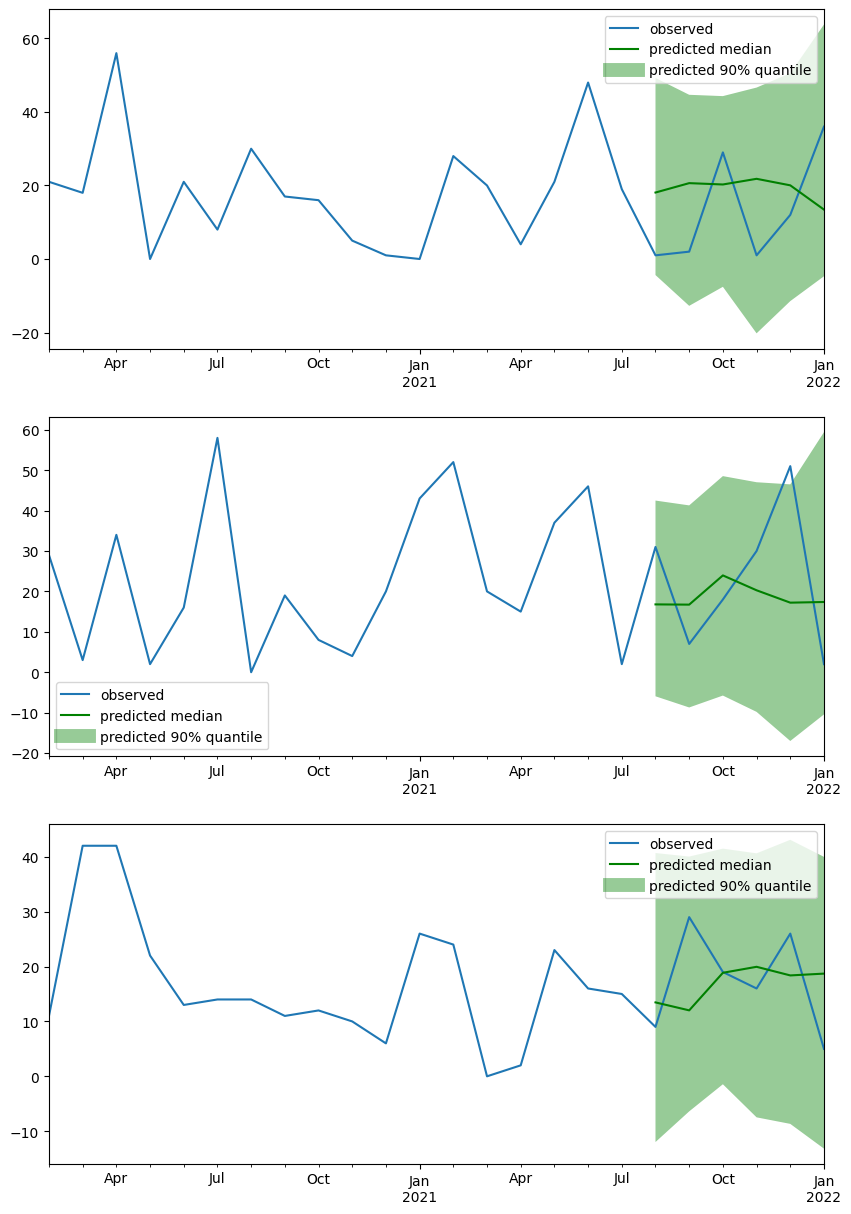

In [84]:
from matplotlib import pyplot as plt

n_plot = 3
indices = [0,1,2]
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    tss[index][-4 * prediction_length :].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(prediction_intervals=[90.0], color="g")
    plt.legend(["observed", "predicted median", "predicted 90% quantile"])

# Criando classes para pipeline em DeepAr

## Pré processamento

In [11]:
class pre_process:
    
    def pre_process_deepar(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None), prediction_length = 6):
        data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]
        data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
        data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")
        
        data_para_processamento_new = pd.DataFrame(None, columns = data_para_processamento.columns)
        for n in data_para_processamento.NUMERO_REGISTRO_PRODUTO.unique():
            frame_train = data_para_processamento.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iloc[:-prediction_length]
            data_para_processamento_new = pd.concat([data_para_processamento_new, frame_train])
            
        train = PandasDataset.from_long_dataframe(data_para_processamento_new, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        
        return train, test
    
    def pre_process_deepar_predict(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)):
        data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]
        data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
        data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")
        
        test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        
        return test

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [13]:
train, test = pre_process.pre_process_deepar()

C:\Users\anton\AppData\Local\Temp\ipykernel_7736\3993147561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


In [16]:
serie_predict = pre_process.pre_process_deepar_predict()

C:\Users\anton\AppData\Local\Temp\ipykernel_7736\3993147561.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


## Treinamento

In [24]:
class train_model:
    
    def train_deepAR(data_train,
                     freq="M",
                     prediction_length=6,
                     context_length=16,
                     num_layers=2,
                     num_cells=50,
                     learning_rate=0.01,
                     epochs=10):
        
        callbacks = [LearningRateReduction(objective="min", patience=10, base_lr=1e-3, decay_factor=0.5),
                        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))]

        estimator = DeepAREstimator(freq=freq,
                                    prediction_length=prediction_length,
                                    context_length=context_length,
                                    num_layers = num_layers,
                                    num_cells = num_cells,
                                    trainer=Trainer(#ctx = mx.context.gpu(),
                                                    epochs=epochs,
                                                    learning_rate=learning_rate,
                                                    callbacks=callbacks))

        predictor = estimator.train(data_train)
        pd.to_pickle(predictor,'../../data/models/deepAR_model.pickle' )
        return predictor

In [25]:
train_model.train_deepAR(train)

100%|████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.07it/s, epoch=10/10, avg_epoch_loss=4.16]


## Predição

In [18]:
import sys
sys.path.insert(1, '../pre_train/')
import load_data

class metods_predict:
    """
    Classe que contém métodos para realizar as predições, tanto dos modelos quanto das outras técnicas para comparação.
    """
    
    def predict_model_deepAR(data_test, predictor):
        forecast_it, ts_it = make_evaluation_predictions(dataset=data_test, predictor=predictor, num_samples=1)

        forecasts = list(forecast_it)
        tss = list(ts_it)
        
        load_data.conect_data.save_table(data_predict_media_movel, '../../../data/data_processed/', 'processed.predict', 'csv')
    
    def predict_mean(data=load_data.conect_data.load_table('../../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)):
        """
        Método que calcula a predição baseado na média móvel.

        Args:
            data (Dataframe, optional): Tabela de input com valores para calcular a curva ABC. Defaults to load_data.conect_data.load_table('../../../data/data_ingestion/', 'ingestion.itens_input_mvp', 'csv', sep=None).
        """
        data_predict_media_movel = data[["NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO","QUANTIDADE_SAIDA"]]
        
        predict_media = []
        for item in data_predict_media_movel["NUMERO_REGISTRO_PRODUTO"].unique():
            serie_itens = data_predict_media_movel.query(f"NUMERO_REGISTRO_PRODUTO == {item}")
            media_movel = list(serie_itens.QUANTIDADE_SAIDA.shift(1).rolling(3).mean())
            for n in media_movel[:]:
                predict_media.append(n)
                
        data_predict_media_movel["PREDICAO_MEDIA_MOVEL"] = predict_media
        
        load_data.conect_data.save_table(data_predict_media_movel, '../../../data/data_processed/', 'processed.predict', 'csv')

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


FileNotFoundError: [Errno 2] No such file or directory: '../../../data/data_ingestion//ingestion.itens_output_mvp.csv'

## Avaliação